<a href="https://colab.research.google.com/github/tawfiqam/MI564/blob/main/Interpretability_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML Interpretability

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.rcParams.update({'font.size':20,'figure.figsize':(15,12)})

In [2]:
#These are transformer functions to allow me to calculate the p-values and others


def get_p_values(model, X):
    denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
    F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.pinv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
    z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
    return p_values

# The source for this is from here:
# https://gist.github.com/lqdc/1ea1682ad1214956d95904ebde3134a5
def get_se(X, y, model):
    """StdErr per variable estimation.
    https://en.wikipedia.org/wiki/Ordinary_least_squares
    """
    MSE = np.mean((y - model.predict(X).T)**2)
    # numerically unstable below with openblas if rcond is less than that
    var_est = MSE * np.diag(np.linalg.pinv(np.dot(X.T, X), rcond=1e-10))
    SE_est = np.sqrt(var_est)
    return SE_est

def decision(coefs, X, intercept):
    return np.dot(X, coefs) + intercept

def get_probs(model, X, SE_est, z=1.96):
    """Estimate CI given data, StdErrors and model."""
    coefs = np.ravel(model.coef_)
    upper = coefs + (z * SE_est)
    lower = coefs - (z * SE_est)

    prob = 1. / (1. + np.exp(-decision(coefs, X, model.intercept_)))
    upper_prob = 1. / (1. + np.exp(-decision(upper, X, model.intercept_)))
    lower_prob = 1. / (1. + np.exp(-decision(lower, X, model.intercept_)))

    stacked = np.vstack((lower_prob, upper_prob))
    up = np.max(stacked, axis=0)
    lo = np.min(stacked, axis=0)
    return prob, upper, lower

def get_odd_ratio(model):
  return np.exp(model.coef_[0])

You can get the dataset [here](https://drive.google.com/file/d/1_QHXufXtqn9ozhZZl8lDvA4DHH9pgfnV/view?usp=sharing). The source for the dataset is [here](https://web.stanford.edu/~hastie/ElemStatLearn/). This dataset is about predicting heart disease. 

In [3]:
df = pd.read_csv('SAheart.csv')

In [4]:
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [5]:
#create a dictionary to map strings to boolean values
# 1 is Present and 0 ais Absent
d = {'Present': 1, 'Absent': 0}
# Now process the column to reflect the mapping
df['famhist']=df['famhist'].map(d)

In [6]:
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [7]:
#we do not need row.names in our analysis (identifies patient)
del df['row.names']

In [8]:
X = df[df.columns[:-1]]

In [9]:
feature_list = df[df.columns[:-1]].columns

In [10]:
y = df['chd']

In [11]:
X

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49
...,...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,31.72,0,64,28.45,0.00,58
458,182,4.20,4.41,32.10,0,52,28.61,18.72,52
459,108,3.00,1.59,15.23,0,40,20.09,26.64,55
460,118,5.40,11.61,30.79,0,64,27.35,23.97,40


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.3)
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

In [13]:
clf = MLPClassifier(activation='logistic',random_state=1).fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

0.7194244604316546


In [14]:
!pip install interpret

     |████████████████████████████████| 5.8MB 8.2MB/s 
     |████████████████████████████████| 5.6MB 46.1MB/s 
     |████████████████████████████████| 1.8MB 33.2MB/s 
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 3.6MB 41.9MB/s 
     |████████████████████████████████| 296kB 58.1MB/s 
     |████████████████████████████████| 276kB 59.0MB/s 
     |████████████████████████████████| 788kB 41.1MB/s 
     |████████████████████████████████| 122kB 41.1MB/s 
     |████████████████████████████████| 860kB 26.8MB/s 
     |████████████████████████████████| 358kB 47.3MB/s 
     |████████████████████████████████| 256kB 62.4MB/s 
     |████████████████████████████████| 1.0MB 47.3MB/s 
     |████████████████████████████████| 3.5MB 30.2MB/s 
     |████████████████████████████████| 92kB 7.1MB/s 
     |████████████████████████████████| 368kB 52.4MB/s 
     |████████████████████████████████| 358kB 46.2MB/s 
  Created wheel for dash-table: filename=dash_table-4

##Interpret ML graphs ROC for you if you like

In [15]:
from interpret import show
from interpret.perf import ROC

In [16]:
blackbox_perf = ROC(clf.predict_proba).explain_perf(X_test, y_test, name='Blackbox')
show(blackbox_perf)

/usr/local/lib/python3.7/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


##Main use of ML Interpret

We want to get the global sensitivity. This means that we don't want to explain just one prediction...we want to explain how our model works. 


These are called global explanations representing how the model behaves overall.


In [17]:
from interpret.blackbox import MorrisSensitivity

sensitivity = MorrisSensitivity(predict_fn=clf.predict_proba, data=X_train)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")

show(sensitivity_global)

##Let's try logsitic regression

In [18]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
# we will be changing the parameters going forward
logreg = LogisticRegression(max_iter=1000)

# fit the model with data
logreg.fit(X_train,y_train)

#now the predictions are in y_pred
y_pred=logreg.predict(X_test)

In [19]:
import numpy as np
import scipy.stats as stat
import seaborn as sns

###There's a bunch of helper functions for me to get the p-values, standard error etc. 

No handles with labels found to put in legend.


Text(0.5, 0, 'Feature')

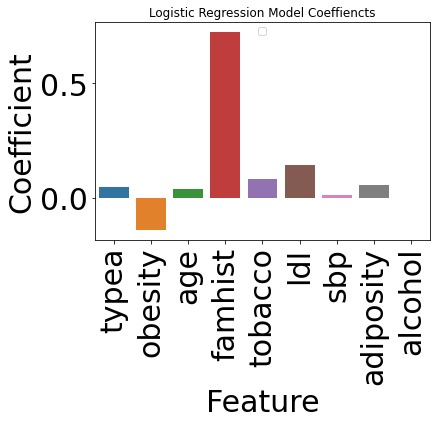

In [20]:
top_model = logreg
#getting p-values
p_values = get_p_values(top_model, X_train)
#getting standard error
SE_est = get_se(X_train, y_train, logreg)
prob, up, lo = get_probs(top_model,X_train, SE_est)
#getting odds ratio
OR = get_odd_ratio(top_model)
#putting them all together
predict_score = list(zip(feature_list, top_model.coef_[0], p_values,OR,up, lo))
#sort according to p-vale (to know which are significant values)
predict_score_sorted = sorted(predict_score, key=lambda tup: tup[2])
predictions = pd.DataFrame(predict_score_sorted, columns=['predictor', 'importance','p-values','OR','up','low'])
predictions = predictions.sort_values(['p-values'], ascending=True)
#predictions.plot()
tab = sns.barplot(x="predictor", y="importance", data=predictions[0:10])
tab.tick_params(labelsize=30)
plt.legend(loc=9)
plt.fontsize=20
plt.rcParams['figure.figsize']=(50,20)
plt.title('Logistic Regression Model Coeffiencts')
plt.xticks(rotation='90')
plt.ylabel('Coefficient', fontsize=30)
plt.xlabel('Feature',fontsize=30)

array([[79, 14],
       [25, 21]])

'Accuracy:      0.7194244604316546  '

'Precision:     0.6                 '

'Recall:        0.45652173913043476 '

'f1 score:      0.5185185185185185  '

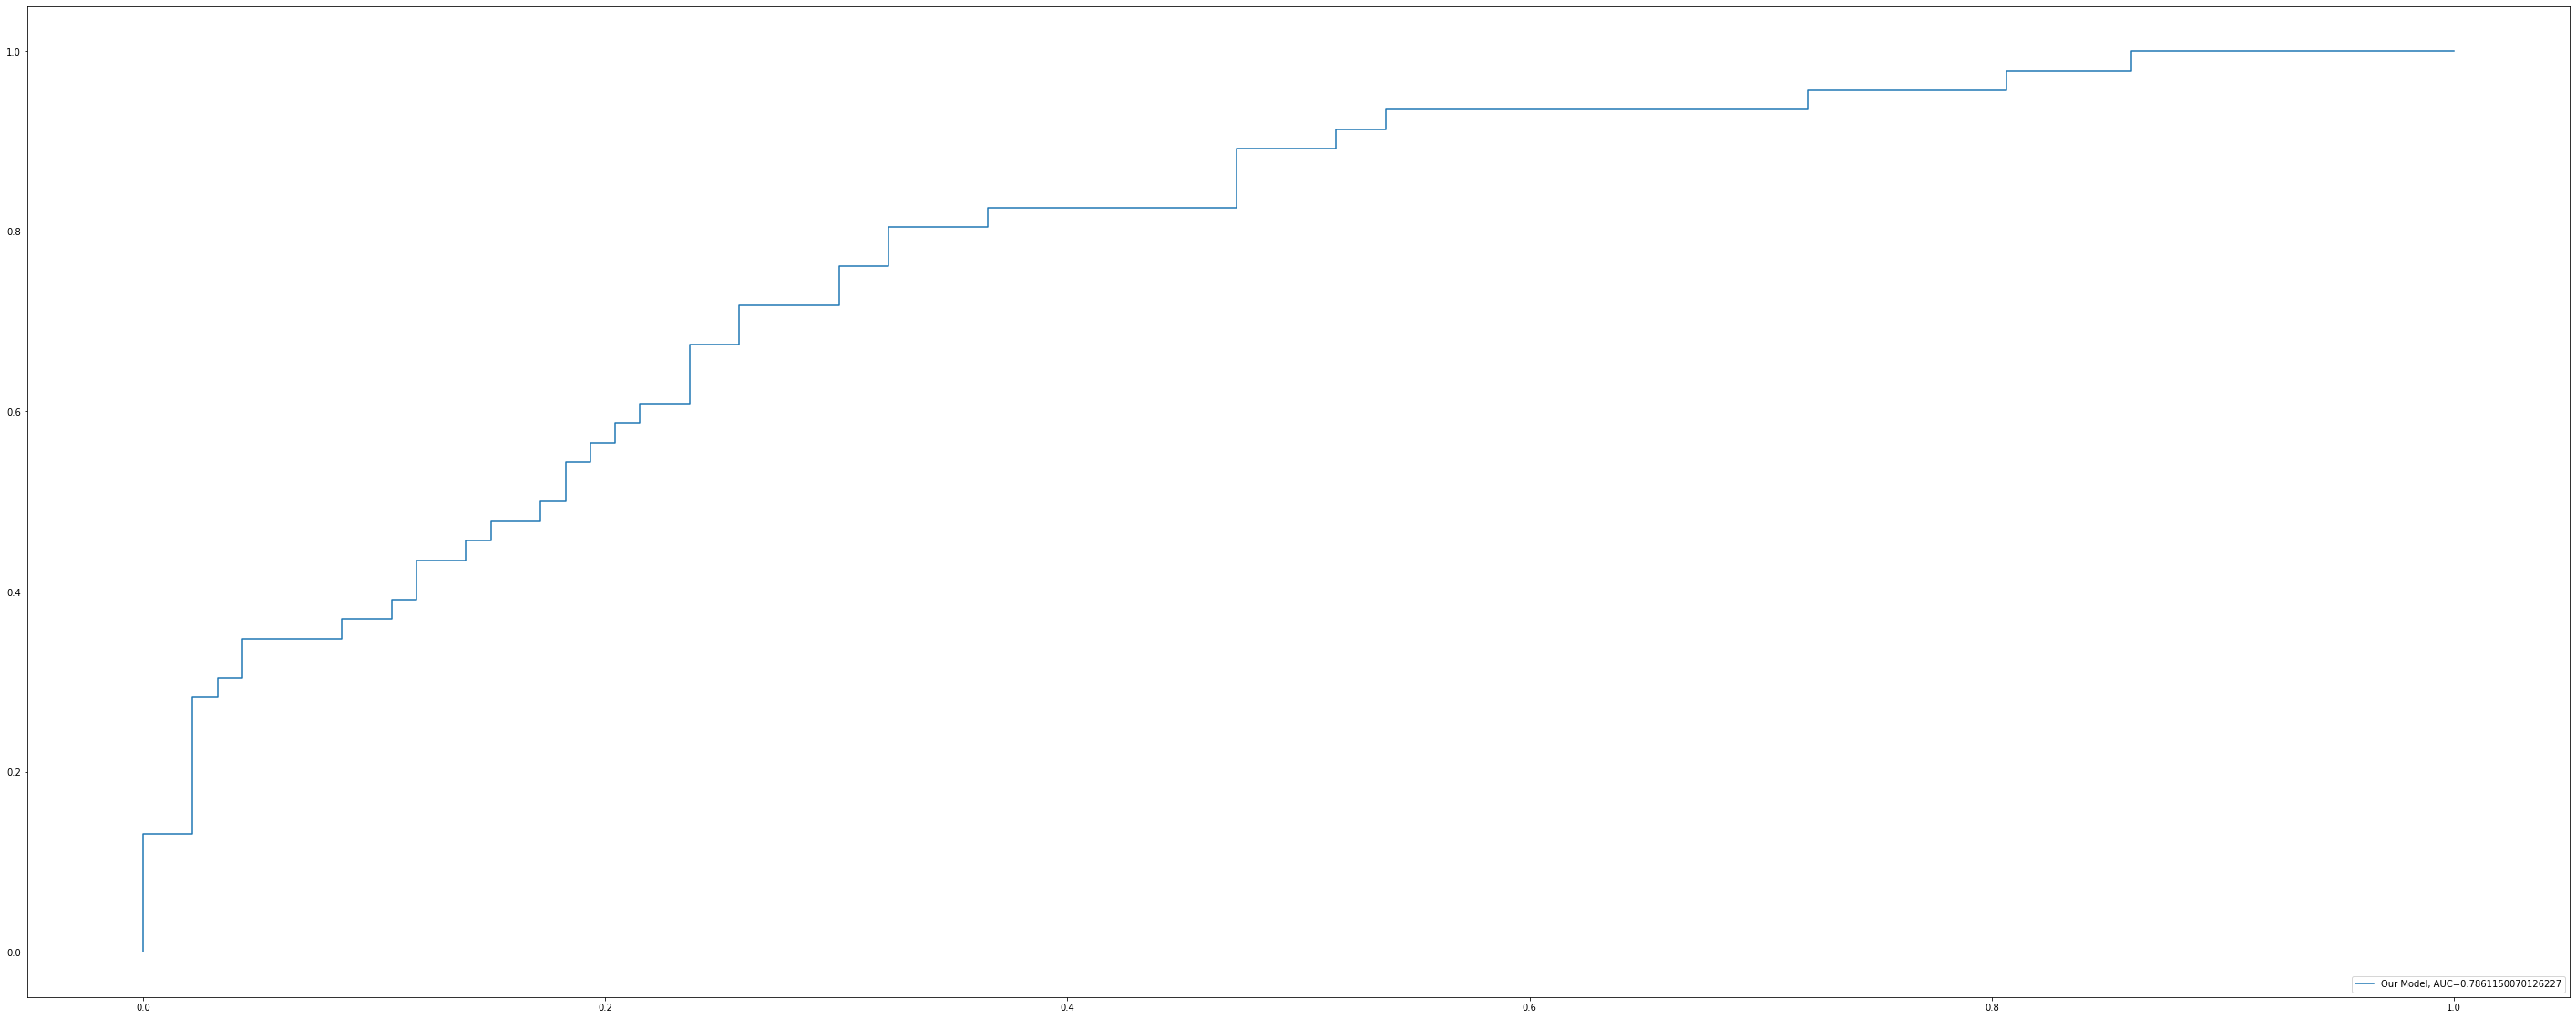

In [21]:
from sklearn import metrics

#now the predictions are in y_pred
y_pred=logreg.predict(X_test)

#import the metrics class
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
display(cnf_matrix)

display('{:<15s}{:<20s}'.format('Accuracy:',str(metrics.accuracy_score(y_test,y_pred))))
display('{:<15s}{:<20s}'.format('Precision:',str(metrics.precision_score(y_test,y_pred,average='binary'))))
display('{:<15s}{:<20s}'.format('Recall:',str(metrics.recall_score(y_test,y_pred, average='binary'))))
display('{:<15s}{:<20s}'.format('f1 score:',str(metrics.f1_score(y_test,y_pred, average='binary'))))


y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Our Model, AUC="+str(auc))
plt.fontsize=30
plt.legend(loc=4)
plt.show()